Generated Dataset:
   arrival_rate  service_time  num_doctors  sim_time  waiting_time
0     27.794915     16.555090            2       240     88.085184
1     39.665009     23.745648            6       240     67.930637
2      6.099840     13.869845            5       240      0.000000
3     17.772872     29.083226            7       240      3.766496
4     30.614014     10.699144            8       240      0.499199

Dataset saved as simulation_dataset.csv

Model Performance:
                                R2        MAE       RMSE
Linear Regression         0.845039   9.606689  12.184035
Random Forest             0.942185   4.970029   7.442211
Gradient Boosting         0.932597   6.304249   8.035630
Support Vector Regressor  0.048241  26.790801  30.195601
KNN Regressor             0.891012   7.008650  10.218086
XGBoost                   0.933429   5.347592   7.985891

Best Model based on R² Score: Random Forest


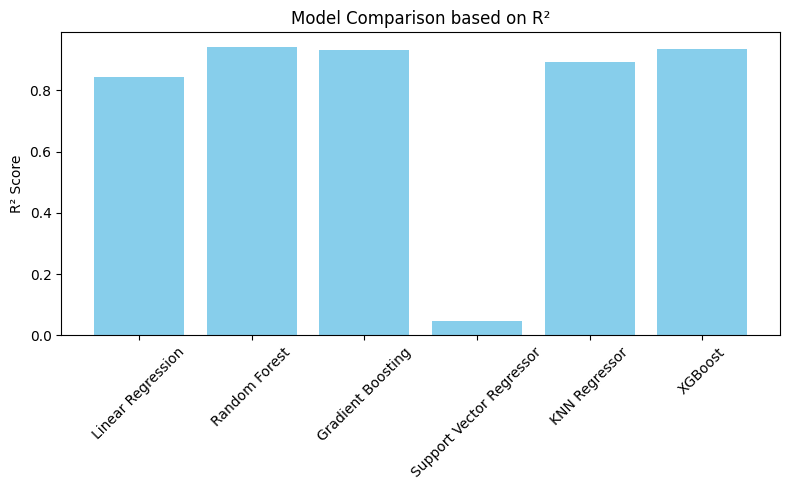


Plot saved as model_r2_scores.png


In [1]:
!pip install simpy xgboost

import simpy
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

def patient(env, doctors, service_time, results):
    arrival_time = env.now
    with doctors.request() as req:
        yield req
        wait = env.now - arrival_time
        yield env.timeout(service_time)
        results['waiting_times'].append(wait)

def simulate(arrival_rate, service_time, num_doctors, sim_time):
    env = simpy.Environment()
    doctors = simpy.Resource(env, capacity=num_doctors)
    results = {'waiting_times': []}

    def arrival_process(env):
        while True:
            yield env.timeout(np.random.exponential(60/arrival_rate))
            env.process(patient(env, doctors, service_time, results))

    env.process(arrival_process(env))
    env.run(until=sim_time)

    if len(results['waiting_times']) == 0:
        return 0
    return np.mean(results['waiting_times'])

data = []
for _ in range(1000):
    arrival_rate = random.uniform(5, 40)
    service_time = random.uniform(10, 45)
    num_doctors = random.randint(1, 10)
    sim_time = 240  # 4 hours

    waiting_time = simulate(arrival_rate, service_time, num_doctors, sim_time)

    data.append([arrival_rate, service_time, num_doctors, sim_time, waiting_time])

df = pd.DataFrame(data, columns=['arrival_rate', 'service_time', 'num_doctors', 'sim_time', 'waiting_time'])
df.to_csv("simulation_dataset.csv", index=False)

print("Generated Dataset:")
print(df.head())
print("\nDataset saved as simulation_dataset.csv")

X = df[['arrival_rate', 'service_time', 'num_doctors', 'sim_time']]
y = df['waiting_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Support Vector Regressor": SVR(),
    "KNN Regressor": KNeighborsRegressor(),
    "XGBoost": XGBRegressor(objective='reg:squarederror')
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results[name] = {
        "R2": r2_score(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred))
    }

results_df = pd.DataFrame(results).T
print("\nModel Performance:")
print(results_df)

best_model = results_df['R2'].idxmax()
print("\nBest Model based on R² Score:", best_model)

plt.figure(figsize=(8,5))
plt.bar(results_df.index, results_df['R2'], color='skyblue')
plt.ylabel("R² Score")
plt.title("Model Comparison based on R²")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("model_r2_scores.png")
plt.show()

print("\nPlot saved as model_r2_scores.png")
